In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.utils import shuffle

In [26]:
def init_parameters(layers):
    parameters ={}
    grads = {}
    for l in range(1,len(layers)):
        parameters['W'+str(l)] = np.random.randn(layers[l],layers[l-1]) * 0.01
        parameters['b'+str(l)] = np.zeros((layers[l],1))
        parameters['bngm'+str(l)] = np.ones((layers[l],1))
        parameters['bnbeta'+str(l)] = np.zeros((layers[l],1))
        
    for l in range(1,len(layers)):
        grads['dw'+str(l)] = np.zeros((layers[l],layers[l-1]))
        grads['db'+str(l)] = np.zeros((layers[l],1))
        grads['dhi'+str(l)] = np.zeros((layers[l],layers[l-1]))
        grads['dho'+str(l)] = np.zeros((layers[l],layers[l-1]))
        grads['dv'+str(l)] = np.zeros((layers[l],layers[l-1]))
        grads['ds'+str(l)] = np.zeros((layers[l],layers[l-1]))
        grads['dbngm'+str(l)] = np.zeros((layers[l],1))
        grads['dbnbeta'+str(l)] = np.zeros((layers[l],1))
    return parameters, grads
        


In [263]:
#Reference : http://cthorey.github.io./backpropagation/

def bn_ff(h,gamma,beta,N):
    mu = 1/N*np.sum(h,axis =1,keepdims=True) # Size (H,) 
    sigma2 = 1/N*np.sum((h-mu)**2,axis=1,keepdims=True)# Size (H,) 
    hath = (h-mu)*(sigma2+epsilon)**(-1./2.)
    y = gamma*hath+beta 
    return y

def bn_bp(dy,h,gamma,beta,N):
    mu = 1./N*np.sum(h, axis = 1,keepdims=True)
    var = 1./N*np.sum((h-mu)**2, axis = 1,keepdims=True)
    dbeta = np.sum(dy, axis=1,keepdims=True)
    dgamma = np.sum((h - mu) * (var + epsilon)**(-1. / 2.) * dy, axis=1,keepdims=True)
    dh = (1. / N) * gamma * (var + epsilon)**(-1. / 2.) * \
    (N * dy - np.sum(dy, axis=1,keepdims=True) - (h - mu) * (var + epsilon)**(-1.0) * np.sum(dy * (h - mu), axis=1,keepdims=True))
    return dbeta,dgamma,dh



In [28]:
def relu(x):
    return np.maximum(0,x)
def sigmoid(x):
    return 1/(1+np.exp(-x))
def d_relu(x):
    return ((x>0).astype(np.int16)) 
def d_sigmoid(x):
    return x * (1-x)
def softmax(x):
    return np.exp(x)/np.sum(np.exp(x))
# def d_softmax(x):


In [29]:
def feedForward(h_layers,h_activations,X,parameters,bias=False):
    #Bias addition,Batch Normalization, Optimization
    cache ={}
    #first column contains X as input 
    if bias:
        cache['ho'+str(0)]= X
        cache['hi'+str(1)] = np.dot(parameters['W'+str(1)],cache['ho'+str(0)])+ parameters['b'+str(1)]
        
        if h_activations[0]=='relu':
            cache['ho'+str(1)] = relu(cache['hi'+str(1)])
        if h_activations[0] == 'sigmoid':
            cache['ho'+str(1)] = sigmoid(cache['hi'+str(1)])

        # start from 2nd column for hidden layers and output layer.
        for l in range(2,len(h_layers)):
            cache['hi'+str(l)] = np.dot(parameters['W'+str(l)],cache['ho'+str(l-1)])+ parameters['b'+str(l)]
            if h_activations[l-1] =='relu':
                cache['ho'+str(l)] = relu(cache['hi'+str(l)])
            if h_activations[l-1] == 'sigmoid':
                cache['ho'+str(l)] = sigmoid(cache['hi'+str(l)])
    else:
        cache['ho'+str(0)]= X
        cache['hi'+str(1)] = np.dot(parameters['W'+str(1)],cache['ho'+str(0)])
        if h_activations[0]=='relu':
            cache['ho'+str(1)] = relu(cache['hi'+str(1)])
        if h_activations[0] == 'sigmoid':
            cache['ho'+str(1)] = sigmoid(cache['hi'+str(1)])

        # start from 2nd column for hidden layers and output layer.
        for l in range(2,len(h_layers)):
            cache['hi'+str(l)] = np.dot(parameters['W'+str(l)],cache['ho'+str(l-1)])
            if h_activations[l-1] =='relu':
                cache['ho'+str(l)] = relu(cache['hi'+str(l)])
            if h_activations[l-1] == 'sigmoid':
                cache['ho'+str(l)] = sigmoid(cache['hi'+str(l)])
        
    return cache
    


In [146]:
def bNfeedForward(h_layers,h_activations,X,parameters,grads,m,bias=False):
    #Bias addition,Batch Normalization, Optimization
    cache ={}
    #first column contains X as input 
    if bias:
        cache['ho'+str(0)]= X
        cache['hi'+str(1)] = np.dot(parameters['W'+str(1)],cache['ho'+str(0)])+ parameters['b'+str(1)]        
        cache['hiBN'+str(1)] = bn_ff(cache['hi'+str(1)],parameters['bngm'+str(1)],parameters['bnbeta'+str(1)],m)
    
        if h_activations[0]=='relu':
            cache['ho'+str(1)] = relu(cache['hiBN'+str(1)])
        if h_activations[0] == 'sigmoid':
            cache['ho'+str(1)] = sigmoid(cache['hiBN'+str(1)])

        # start from 2nd column for hidden layers and output layer.
        for l in range(2,len(h_layers)):
            cache['hi'+str(l)] = np.dot(parameters['W'+str(l)],cache['ho'+str(l-1)])+ parameters['b'+str(l)]
            cache['hiBN'+str(l)] = bn_ff(cache['hi'+str(l)],parameters['bngm'+str(l)],parameters['bnbeta'+str(l)],m)
            if h_activations[l-1] =='relu':
                cache['ho'+str(l)] = relu(cache['hiBN'+str(l)])
            if h_activations[l-1] == 'sigmoid':
                cache['ho'+str(l)] = sigmoid(cache['hiBN'+str(l)])
    else:
        cache['ho'+str(0)]= X
        cache['hi'+str(1)] = np.dot(parameters['W'+str(1)],cache['ho'+str(0)])
        cache['hiBN'+str(1)] = bn_ff(cache['hi'+str(1)],parameters['bngm'+str(1)],parameters['bnbeta'+str(1)],m)
        if h_activations[0]=='relu':
            cache['ho'+str(1)] = relu(cache['hiBN'+str(1)])
        if h_activations[0] == 'sigmoid':
            cache['ho'+str(1)] = sigmoid(cache['hiBN'+str(1)])

        # start from 2nd column for hidden layers and output layer.
        for l in range(2,len(h_layers)):
            cache['hi'+str(l)] = np.dot(parameters['W'+str(l)],cache['ho'+str(l-1)])
            cache['hiBN'+str(l)] = bn_ff(cache['hi'+str(l)],parameters['bngm'+str(l)],parameters['bnbeta'+str(l)],m)
            if h_activations[l-1] =='relu':
                cache['ho'+str(l)] = relu(cache['hiBN'+str(l)])
            if h_activations[l-1] == 'sigmoid':
                cache['ho'+str(l)] = sigmoid(cache['hiBN'+str(l)])
    return cache
    



In [31]:
def backProp(cache,Y,h_activations,grads,parameters):
    """
    Backpropogation rules:
    1. reshape the X  and Y values to [featrues * examples] 
    2. Initialize first layers weights according to the X featrues size as input 
    3. Initialize last layers weights according the Y features size as output
    4. While initializing weights take current layer size as row value and preivous layer size as column value [R X C]
    5. While back propogating we find the derivatives of input and output of each layers first.
    6. We need to mulitply previous layers(from backward previous layer) derivative with the current layer derivative(chain rule)
    7. Last layer will only contain Input derivative with respect to loss function
    8. After layers output and input using these values we find weights and biases derivatives.
    9. hidden layers(exlcuding input and output layers) typical formula is
        1.Output : dot product of weights of next layer and Input derivate of next layer
            Ex : dHO(L) = np.dot(weights.T , DHI(L+1)
                 dHI(L) = activation function output * dHO(L)
                 dW(L) = (1/m) * np.dot( dHI(L), HO(L-1).T )
                 dB(L) = sum(dHI(L),axis=1)
                 
            L represents current layers
            m is the number of examples

    """
    
    #start from last layer with loss function
    l = len(h_activations)
    m = cache['ho'+str(l-1)].shape[1]
    
    grads['dhi'+str(l)] = cache['hi'+str(l)] - Y 
    grads['dw'+str(l)] =(1/m) * np.dot(grads['dhi'+str(l)],cache['ho'+str(l-1)].T) 
    grads['db'+str(l)] = (1/m) * np.sum(grads['dhi'+str(l)],axis=1,keepdims=True )

    for l in range(len(h_activations)-1,0,-1):
        m = cache['ho'+str(l)].shape[1]
        grads['dho'+str(l)] =np.dot(parameters['W'+str(l+1)].T,grads['dhi'+str(l+1)])
        
        if h_activations[l] =='relu':
            grads['dhi'+str(l)] = grads['dho'+str(l)] * d_relu(cache['hi'+str(l)])
        if h_activations[l] =='sigmoid':
            grads['dhi'+str(l)] = grads['dho'+str(l)] * d_sigmoid(cache['hi'+str(l)])
        
        grads['dw'+str(l)] = (1/m) * np.dot(grads['dhi'+str(l)],cache['ho'+str(l-1)].T ) 
        grads['db'+str(l)] = (1/m) * np.sum(grads['dhi'+str(l)] ,axis=1,keepdims=True)

    return grads



In [169]:
def bNbackProp(cache,Y,h_activations,grads,parameters):
    """
    Backpropogation rules:
    1. reshape the X  and Y values to [featrues * examples] 
    2. Initialize first layers weights according to the X featrues size as input 
    3. Initialize last layers weights according the Y features size as output
    4. While initializing weights take current layer size as row value and preivous layer size as column value [R X C]
    5. While back propogating we find the derivatives of input and output of each layers first.
    6. We need to mulitply previous layers(from backward previous layer) derivative with the current layer derivative(chain rule)
    7. Last layer will only contain Input derivative with respect to loss function
    8. After layers output and input using these values we find weights and biases derivatives.
    9. hidden layers(exlcuding input and output layers) typical formula is
        1.Output : dot product of weights of next layer and Input derivate of next layer
            Ex : dHO(L) = np.dot(weights.T , DHI(L+1)
                 dHI(L) = activation function output * dHO(L)
                 dW(L) = (1/m) * np.dot( dHI(L), HO(L-1).T )
                 dB(L) = sum(dHI(L),axis=1)
                 
            L represents current layers
            m is the number of examples

    """
    
    #start from last layer with loss function
    l = len(h_activations)
    m = cache['ho'+str(l-1)].shape[1]
    
    grads['dhiBN'+str(l)] = cache['hiBN'+str(l)] - Y 
    grads['dbnbeta'+str(l)], grads['dbngm'+str(l)], grads['dhi'+str(l)] = bn_bp(grads['dhiBN'+str(l)],cache['hi'+str(l)],grads['dbngm'+str(l)],grads['dbnbeta'+str(l)],m)
    
    grads['dw'+str(l)] =(1/m) * np.dot(grads['dhi'+str(l)],cache['ho'+str(l-1)].T) 
    grads['db'+str(l)] = (1/m) * np.sum(grads['dhi'+str(l)],axis=1,keepdims=True)    
    

    for l in range(len(h_activations)-1,0,-1):
        m = cache['ho'+str(l)].shape[1]
        grads['dho'+str(l)] =np.dot(parameters['W'+str(l+1)].T,grads['dhiBN'+str(l+1)])
        
        if h_activations[l] =='relu':
            grads['dhiBN'+str(l)] = grads['dho'+str(l)] * d_relu(cache['hiBN'+str(l)])
            grads['dbnbeta'+str(l)], grads['dbngm'+str(l)],grads['dhi'+str(l)] = bn_bp(grads['dhiBN'+str(l)],cache['hi'+str(l)],grads['dbngm'+str(l)],grads['dbnbeta'+str(l)],m)
        if h_activations[l] =='sigmoid':
            grads['dhiBN'+str(l)] = grads['dho'+str(l)] * d_sigmoid(cache['hiBN'+str(l)])
            grads['dbnbeta'+str(l)], grads['dbngm'+str(l)],grads['dhi'+str(l)] = bn_bp(grads['dhiBN'+str(l)],cache['hi'+str(l)],grads['dbngm'+str(l)],grads['dbnbeta'+str(l)],m)


        grads['dw'+str(l)] = (1/m) * np.dot(grads['dhi'+str(l)],cache['ho'+str(l-1)].T ) 
        grads['db'+str(l)] = (1/m) * np.sum(grads['dhi'+str(l)] ,axis=1,keepdims=True)

    return grads




In [320]:
def update_grads(grads,learning_rate,parameters):
    for l in range(1,len(h_layers)):
        parameters['W'+str(l)] = parameters['W'+str(l)] - learning_rate * grads['dw'+str(l)]
        parameters['b'+str(l)] = parameters['b'+str(l)] - learning_rate * grads['db'+str(l)]
        parameters['bngm'+str(l)] = parameters['bngm'+str(l)] - learning_rate * grads['dbngm'+str(l)]
        parameters['bnbeta'+str(l)]= parameters['bnbeta'+str(l)] - learning_rate * grads['dbnbeta'+str(l)]
    return parameters
    


In [34]:
def Adam_opt(grads,v_beta,s_beta,l_len,t_correction,eps):
    for l in range(1,l_len+1):
        grads['dv'+str(l)] = grads['dv'+str(l)]* v_beta + (1-v_beta)* grads['dw'+str(l)]
        grads['dv'+str(l)] = grads['dv'+str(l)]/(1 - v_beta**t_correction)
        
        grads['ds'+str(l)] = grads['ds'+str(l)]* s_beta + (1-s_beta)* (grads['dw'+str(l)]**2)
        grads['ds'+str(l)] = grads['ds'+str(l)]/(1 - s_beta**t_correction)
        
        grads['dw'+str(l)] = grads['dv'+str(l)] /np.sqrt(grads['ds'+str(l)] + eps)

    return grads

In [35]:
boston = load_boston()
X, Y = shuffle(boston.data, boston.target, random_state=13)
Y = Y.reshape(1,-1)
X = X.T
X = X.astype(np.float32)
offset = int(X.shape[1] * 0.9)
X_train, y_train = X[:,:offset], Y[:,:offset]
X_test, y_test = X[:,offset:], Y[:,offset:]



In [428]:
##Adam optimization hyper parameters

#momentum
v_beta = 0.8
#RMS prop
s_beta = 0.699


lr = 0.0001
epoch = 10000
epsilon =10**-8
h_layers =[X_train.shape[0],50,20,y_train.shape[0]]
h_act = ['relu','relu','relu'] 
BatchNormalization = False

#initialization
parameters, grads = init_parameters(h_layers)

costl = []
for j in range(epoch):
    
    l_cache = len(h_act)
    m = X_train.shape[1]
    
    #Forward
    if BatchNormalization:
        cache = bNfeedForward(h_layers,h_act,X_train,parameters,grads,m,bias=False)
    else:
        cache = feedForward(h_layers,h_act,X_train,parameters,bias=False)
    
    #check how much the error is , we use this value to find the derivative
    costl.append(np.sum((y_train-cache['ho'+str(l_cache)])**2)/(len(y_train)*2))
        
    if (costl[-1]) >= 0:
        pass
    else:
        break

    #Back propogation (Partial Derivative of output with respect to cost and Average the derivates)
    if BatchNormalization:
        grads = bNbackProp(cache,y_train,h_act,grads,parameters)
    else:
        grads = backProp(cache,y_train,h_act,grads,parameters)

    #Adam Optimization derivates updates
    grads = Adam_opt(grads,v_beta,s_beta,l_cache,j+1,epsilon)
        
    
    #update thetas
    parameters = update_grads(grads,lr,parameters)

    

    
    #plot
    if j%100==0:
        Y_pred =cache['ho'+str(l_cache)]
        print("cost :",costl[-1])
        if BatchNormalization:
            cache_test = bNfeedForward(h_layers,h_act,X_test,parameters,grads,X_test.shape[1],bias=False)
        else:
            cache_test = feedForward(h_layers,h_act,X_test,parameters,bias=False)
        Y_valid_pred = cache_test['ho'+str(l_cache)]
        print("cost :",costl[-1],
              "Test Loss ",mean_squared_error(y_train,Y_pred),
              '#'*5,'validation Loss: ',
              mean_squared_error(y_test,Y_valid_pred))
    #     Y_pred = predict(X_test)
    #     print(mean_squared_error(y_test,Y_pred))
    #     print(mean_squared_log_error(y_test,Y_pred))
    #     print(mean_absolute_error(y_test,Y_pred))




cost : 136550.28999999998
cost : 136550.28999999998 Test Loss  600.2210549450549 ##### validation Loss:  520.1129411764706
cost : 130692.6538264068
cost : 130692.6538264068 Test Loss  574.4732036325573 ##### validation Loss:  495.69325358123467
cost : 113890.87291445397
cost : 113890.87291445397 Test Loss  500.6192216019955 ##### validation Loss:  426.4571484927274
cost : 83501.04041269058
cost : 83501.04041269058 Test Loss  367.037540275563 ##### validation Loss:  302.67133328867146
cost : 47160.74898157356
cost : 47160.74898157356 Test Loss  207.29999552340027 ##### validation Loss:  158.77148485518094
cost : 29734.00205830893
cost : 29734.00205830893 Test Loss  130.69891014641289 ##### validation Loss:  99.39895523945441
cost : 25713.953331132838
cost : 25713.953331132838 Test Loss  113.0283662906938 ##### validation Loss:  84.31751050623771
cost : 22255.449523544456
cost : 22255.449523544456 Test Loss  97.82615175184377 ##### validation Loss:  72.14648544654901
cost : 19545.4653684

cost : 2269.653172736985
cost : 2269.653172736985 Test Loss  9.976497462580154 ##### validation Loss:  15.654819341181375
cost : 2237.633387543692
cost : 2237.633387543692 Test Loss  9.835751154038208 ##### validation Loss:  16.210276642734165
cost : 2211.5603690899597
cost : 2211.5603690899597 Test Loss  9.721144479516306 ##### validation Loss:  16.20982973191551
cost : 2187.599981859181
cost : 2187.599981859181 Test Loss  9.615824096084312 ##### validation Loss:  16.2392578067372
cost : 2161.3670376185637
cost : 2161.3670376185637 Test Loss  9.50051445107061 ##### validation Loss:  16.614661341204037
cost : 2136.5325258851667
cost : 2136.5325258851667 Test Loss  9.3913517621326 ##### validation Loss:  16.618481021993027
cost : 2115.4395782070105
cost : 2115.4395782070105 Test Loss  9.298635508602244 ##### validation Loss:  16.657865992170386
cost : 2091.5993783174267
cost : 2091.5993783174267 Test Loss  9.193843421175503 ##### validation Loss:  16.577397215052624
cost : 2070.74178514

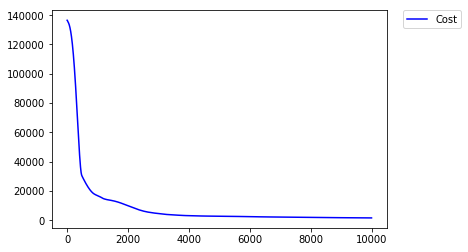

Final Cost:  1662.7842775766983  Length of cost:  10000


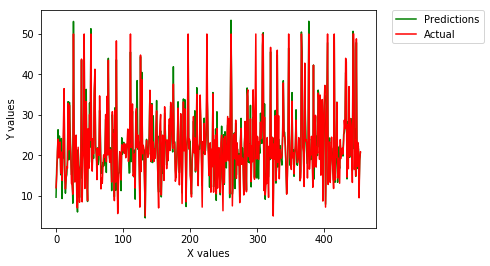

In [429]:
plt.plot(costl,color='Blue',label='Cost')
plt.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)
plt.show()

print("Final Cost: ",costl[-1], " Length of cost: ", len(costl))

plt.plot(Y_pred.ravel(),color='Green',label='Predictions')
plt.plot(y_train.ravel(),color='red',label='Actual')
plt.xlabel("X values")
plt.ylabel("Y values")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()